# Global Effect - An in-depth tutorial

In this tutorial, we will compare all the global effect methods implemented in `Effector`, namely: ALE, RHALE, PDP-ICE, d-PDP-ICE and SHAP Dependence Plots. 
The synthetic example that we will used, was introduced by [(Gkolemis et. al, 2023)](https://arxiv.org/abs/2309.11193).

In [1]:
import numpy as np
import effector
import matplotlib.pyplot as plt

## Problem setup

We will generate $N=60$ examples with $D=3$ features, as described in the following table. Observe that $x_3$ is highly-dependent on $x_1$, i.e., $x_3 \approx x_1$.; this will later help us to compute the ground truth ALE effect.

| Feature | Description                                                           | Distribution                                                                                    |
|---------|-----------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| $x_1$   | $x_1$ lies in $[-0.5, 0.5]$ with most samples in $[-0.5, 0]$          | $x_1 \sim p(x_1) = \frac{5}{6} \mathcal{U}(x_1; -0.5, 0) + \frac{1}{6} \mathcal{U}(x_1; 0, 0.5)$ |
| $x_2$   | Normally distributed with $\mu = 0$, $\sigma = 2$                     | $x_2 \sim p(x_2) = \mathcal{N}(x_2; \mu=0, \sigma = 2)$                                         |
| $x_3$   | $x_3 = x_1 + \delta$, where $\delta \sim \mathcal{N}(0, \sigma=0.01)$ | $x_3 = x_1 + \delta$                                                                            |



In [2]:
def generate_samples(N1, N2, sigma_2=1, sigma_3=.01):
    N = N1 + N2
    x1 = np.concatenate((np.array([-0.5]),
                         np.random.uniform(-0.5, 0, size=int(N1 - 2)),
                         np.array([-0.00001]),
                         np.array([0.]),
                         np.random.uniform(0, 0.5, size=int(N2 - 2)),
                         np.array([0.5])))
    x2 = np.random.normal(0, sigma_2, N)
    x3 = x1 + np.random.normal(0, sigma_3, N)
    x = np.stack([x1, x2, x3], -1)
    return x


np.random.seed(seed=2121)
axis_limits = np.array([[-.5, .5], [-5, 5], [-.5, .5]]).T
sigma_2 = 2
sigma_3 = .01
N1 = 150
N2 = 20
x = generate_samples(N1, N2, sigma_2=sigma_2, sigma_3=sigma_3)

The _black-box_ function is:

$$
f(x) = \sin(2\pi x_1) (\mathbb{1}_{x_1<0} - 2 \mathbb{1}_{x_3<0}) + x_1 x_2 + x_2
$$

For estimating RHALE we also need the jacobian of $f$:

$$
\frac{\partial f}{\partial x} = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \frac{\partial f}{\partial x_3} \end{bmatrix} = \begin{bmatrix} 2\pi x_1 \cos(2\pi x_1) (\mathbb{1}_{x_1<0} - 2 \mathbb{1}_{x_3<0}) + x_2 \\ x_1 + 1 \\ 0 \end{bmatrix}
$$


In [3]:
def f(x):
    """Evaluate function:
    y = sin(2*pi*x1)*(if x1<0) - 2*sin(2*pi*x1)*(if x3<0) + x1*x2 + x2

    """
    y = np.zeros_like(x[:,0])

    ind = np.logical_and(x[:, 0] >= -2, x[:, 0] < 0)
    y[ind] = np.sin(2 * np.pi * x[ind, 0])

    ind = np.logical_and(x[:, 2] >= -2, x[:, 2] < 0)
    y[ind] -= 2 * np.sin(2 * np.pi * x[ind, 0])

    y += x[:, 0] * x[:, 1] + x[:, 1]
    return y

In [4]:
def dfdx(x):
    """Evaluate jacobian of:
    y = sin(2*pi*x1)*(if x1<0) - 2*sin(2*pi*x1)*(if x3<0) + x1*x2 + x2

    dy/dx1 = 2*pi*x1*cos(2*pi*x1)*(if x1<0) - 4*pi*x1*cos(2*pi*x1)*(if x3<0) + x2
    dy/dx2 = x1 + 1
    dy/dx3 = 0
    """

    dydx = np.zeros_like(x)

    ind = np.logical_and(x[:, 0] >= -2, x[:, 0] <= 0)
    dydx[ind, 0] = 2 * np.pi * np.cos(2*np.pi * x[ind, 0])

    ind = np.logical_and(x[:, 2] >= -2, x[:, 2] <= 0)
    dydx[ind, 0] += - 2 * 2 * np.pi * np.cos(2*np.pi * x[ind, 0])

    dydx[:, 0] += x[:, 1]

    dydx[:, 1] = x[:, 0] + 1
    return dydx


## ALE-based methods

### ALE Definition

ALE defines the feature effect as:

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z $$

where $x_s$ is the feature of interest and $x_c$ are the other features. In our case, $x_1$ is the feature of interest and $x_2, x_3$ are the other features.
In the example, given that $x_3 \approx x_1$, it holds that:
 
$$
\mathbb{E}_{x_2, x_3|x_1=z} \left [ \frac{\partial f}{\partial x_1} (z, x_2, x_3) \right ] \approx - 2 \pi z \cos(2 \pi z) \mathbb{1}_{z<0}$, 
$$

and therefore the ALE and RHALE effect is defined as:

$$\text{ALE}(x_1) = \int_{z=0}^{x_1} \mathbb{E}_{x_2, x_3|x_1=z} \left [ \frac{\partial f}{\partial x_1} (z, x_2, x_3) \right ] \partial z
\approx - \sin(2\pi x_1) \mathbb{1}_{x_1<0} + c$$

In [5]:
def ale_gt(x):
    y = np.zeros_like(x)
    ind = x < 0
    y[ind] = - np.sin(2 * np.pi * x[ind])
    c = 0.31
    return y - c

def ale_gt_derivative_effect(x):
    dydx = np.zeros_like(x)
    ind = x < 0
    dydx[ind] = - 2 * np.pi * np.cos(2 * np.pi * x[ind])
    return dydx, sigma_2


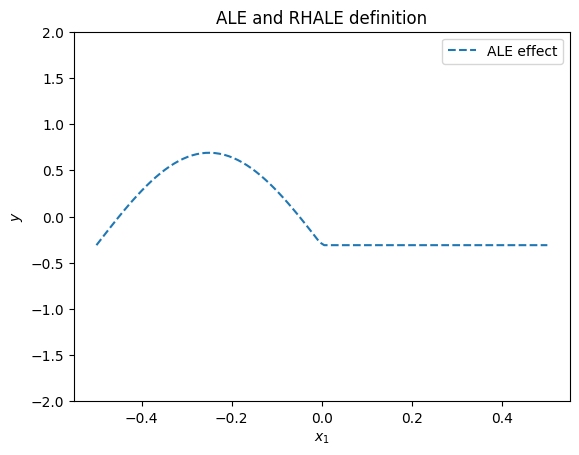

In [6]:
plt.figure()
plt.ylim(-2, 2)
xx = np.linspace(-0.5, 0.5, 100)
plt.plot(xx, ale_gt(xx), "--", label="ALE effect")
plt.title("ALE and RHALE definition")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()
plt.show()

### RHALE definition

RHALE extends ALE definition, adding an heterogeneity term. For visualizing the heterogeneity, RHALE proposes two plots one below the other. The top plot is the RHALE effect which is identical to the ALE effect. The bottom plot is the derivative of the ALE effect and the heterogeneity is the standard deviation of the derivative effect.

RHALE quantifies the heterogeneity as the standard deviation of the derivative of the model with respect to the feature of interest:

$$
\sigma(z) = \sigma_{x_c|x_s=z} \left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ]
$$

The heterogeneity is visualized on top of the ALE effect in two ways. First, as a shaded $\pm$ area around the ALE plot where the area is given by $\pm \sigma(x_s)*x_s$ (aggregated standard deviation). Second, as a shaded area around the derivative of the ALE plot which is defined as $\pm \sigma(x_s)$. In our example, the heterogeneity is:

$$
\sigma(x_1) = \sigma_{x_2, x_3|x_1=z} \left [ \frac{\partial f}{\partial x_1} (z, x_2, x_3) \right ] = \sigma_2
$$

The heterogeneity informs that the instance-level effects are deviating from the average effect by $\pm \sigma_2$.

In [7]:
def rhale_gt(x):
    y = np.zeros_like(x)
    ind = x < 0
    y[ind] = - np.sin(2 * np.pi * x[ind])
    c = 0.31
    return y - c, (x + .5) * sigma_2

def rhale_gt_derivative_effect(x):
    dydx = np.zeros_like(x)
    ind = x < 0
    dydx[ind] = - 2 * np.pi * np.cos(2 * np.pi * x[ind])
    return dydx, sigma_2

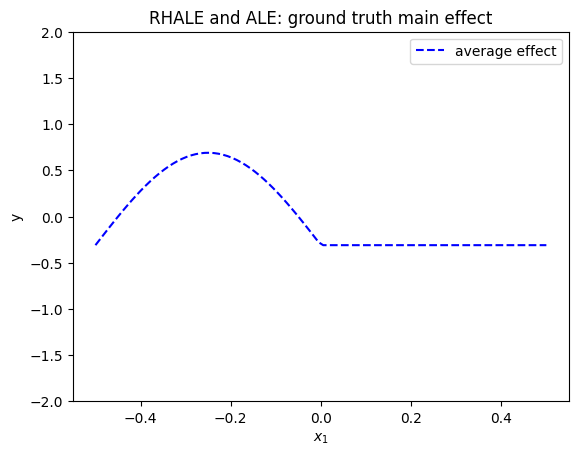

In [8]:
plt.figure()
plt.ylim(-2, 2)
xx = np.linspace(-.5, .5, 100)
plt.plot(xx, rhale_gt(xx)[0], "b--", label="average effect")
plt.title("RHALE and ALE: ground truth main effect")
plt.xlabel("$x_1$")
plt.ylabel("y")
plt.legend()
plt.show()

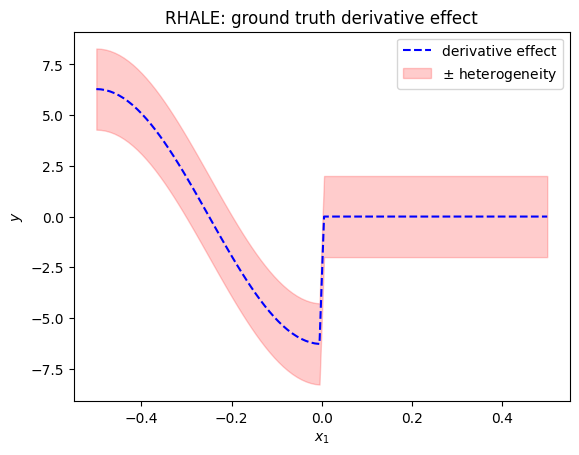

In [9]:
plt.figure()
xx = np.linspace(-0.5, 0.5, 100)
plt.plot(xx, rhale_gt_derivative_effect(xx)[0], "b--", label="derivative effect")
plt.fill_between(xx, rhale_gt_derivative_effect(xx)[0] - rhale_gt_derivative_effect(xx)[1], rhale_gt_derivative_effect(xx)[0] + rhale_gt_derivative_effect(xx)[1], alpha=0.2, label="$\pm$ heterogeneity", color="red")
plt.title("RHALE: ground truth derivative effect")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()
plt.show()

### ALE approximation

Bin splitting is a major limitation of ALE. The user has to choose the number of bins, where different number of bins can lead to very different results. In terms of the main ALE effect, a wrong bin-splitting may lead to unstable results. In terms of the heterogeneity, a wrong bin-splitting may lead to a biased estimation of the heterogeneity. More information can be found at the [RHALE paper](https://arxiv.org/abs/2309.11193).

In our example, if setting a low number of bins (wide bins), e.g., 5, we get the following approximation:

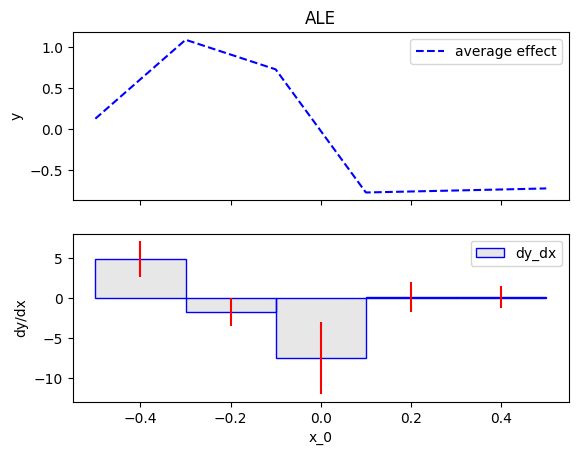

In [10]:
feat = 0
xx = np.linspace(-.5, .5, 100)

# ale 5 bins
nof_bins = 5
# dale = effector.RHALE(data=x, model=f, model_jac=dfdx, axis_limits=axis_limits)
ale = effector.ALE(data=x, model=f, axis_limits=axis_limits)
binning = effector.axis_partitioning.Fixed(nof_bins=nof_bins, min_points_per_bin=0)
ale.fit([feat], binning_method=binning)
ale.plot(feature=feat, heterogeneity=True, centering=True)


The approximation with wide bins has two drawbacks:

* the average ale effect is of low resolution; for example the change in the effect at $x_1=0$ is not captured
* the heterogeneity is biased; for example, the central bin show heterogeneity of $\sigma \approx 4$, where the ground-truth heterogeneity is $\approx 2$.

Let's see what happens with a high number of bins (narrow bins), e.g., 50:

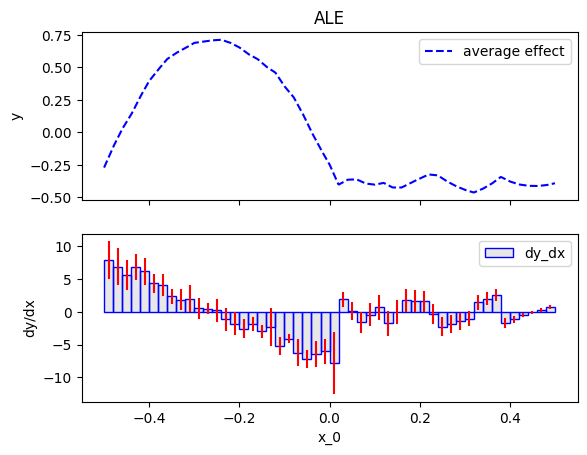

In [11]:
# ale 50 bins
nof_bins = 50
# dale = effector.RHALE(data=x, model=f, model_jac=dfdx, axis_limits=axis_limits)
ale = effector.ALE(data=x, model=f, axis_limits=axis_limits)
binning = effector.axis_partitioning.Fixed(nof_bins=nof_bins, min_points_per_bin=0)
ale.fit([feat], binning_method=binning)
ale.plot(feature=feat, heterogeneity="std", centering=True)

The approximation with narrow bins has two drawbacks:

- the average ale effect is noisy; for example, the effect at $x_1>0$ in not zero.
- the heterogeneity is even more noisy. It has many spikes that are not present in the ground-truth heterogeneity.

In real-world problems, the user has to choose the number of bins without any guidance. This is a major drawback of ALE, because the user does not know which approximation to trust, the one with wide bins or the one with narrow bins. 


### RHALE approximation

RHALE proposes an automatic bin-splitting approach to resolve the issue. Let's first see it practice:

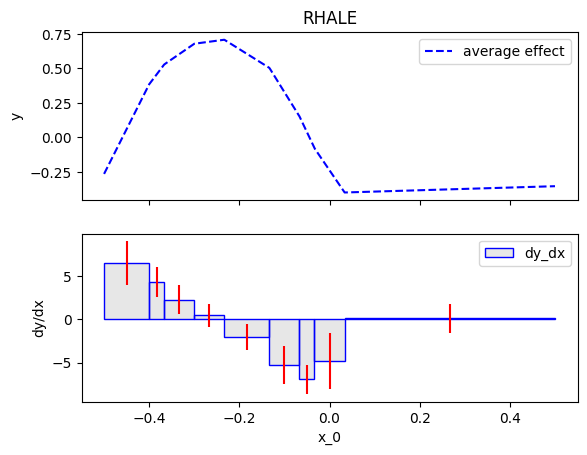

In [12]:
# rhale
feat = 0
rhale = effector.RHALE(data=x, model=f, model_jac=dfdx, axis_limits=axis_limits)
binning = effector.axis_partitioning.DynamicProgramming(max_nof_bins=30, min_points_per_bin=10, discount=0.2)
rhale.fit([feat], binning_method=binning, centering=True)
rhale.plot(feature=feat, heterogeneity="std")

The approximation is much better, both in terms of the average effect and the heterogeneity. For example, the heterogeneity is almost constant around $2$ and the spikes are gone.
This happens due to the automatic bin-splitting, which creates bins of different sizes. In the beginning, area $[-0.5, 0]$, the bins are smaller for a good trade-off between bias and variance. In the end, area $[0, 0.5]$, a single bin is created to limit the variance without adding bias.

### More about the automatic bin-splitting

So, how is the automatic bin-splitting working? 
Before we delve into the details, intutivelly, a wide bin does not (a) sacrifice resolution of the ALE plot and (b) does not introduce bias in the heterogeneity, only in case the effect is linear inside the bin (or the derivative-effect is constant). In our example, this happens in the area, $[0, 0.5]$. Intuitively, bin splitting algorithms search for such areas (to create a single bin there) and in all other cases they try to minimize the bias-variance trade-off.

In `Effector`, there are two automatic bin-splitting methods:

- `Greedy`: the user has to choose the maximum number of bins and the minimum number of samples per bin
- `DynamicProgramming`: the user has to choose the maximum number of bins and the minimum number of samples per bin

#### Greedy approach

`Greedy` has three parameters; `init_nof_bins`, `min_points_per_bin` and `discount`. `max_nof_bins` is the initial (and maximum) number of bins. The algorithm then tries to merge bins in a greedy way, i.e., it moves along the axis (from left to right) and if merging with the next bin leads to a similar variance then it merges the bins. In fact, discount expresses to what extent the algorithm favors the creation of wider bins. The higher the discount the more the algorithm tries to minimize the variance, sacrificing some bias and vice versa. `min_points_per_bin` is the minimum number of samples each bin should have. 


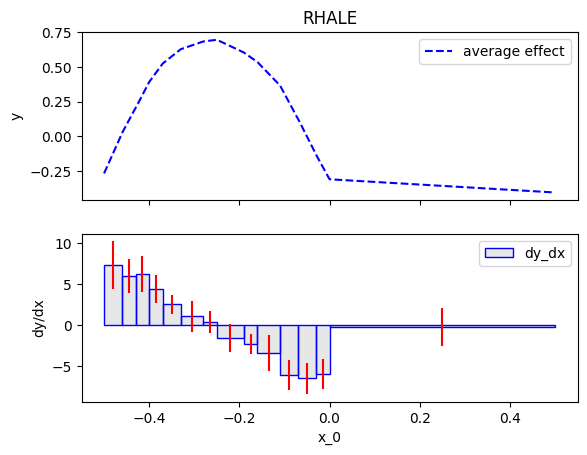

In [13]:
# Greedy
feat = 0
rhale = effector.RHALE(data=x, model=f, model_jac=dfdx, axis_limits=axis_limits)
binning = effector.axis_partitioning.Greedy(init_nof_bins=100, min_points_per_bin=10, discount=0.2)
rhale.fit([feat], binning_method=binning)
rhale.plot(feature=feat, heterogeneity="std", show_avg_output=False)

#### Dynamic Programming approach

`DynamicProgramming` has three parameters; `max_nof_bins`, `min_points_per_bin` and `discount`. `max_nof_bins` is the maximum number of bins. The algorithm then tries to find the optimal binning, i.e., the binning that minimizes the bias-variance trade-off. `min_points_per_bin` is the minimum number of samples each bin should have. `discount` is the discount factor of the algorithm. The higher the discount the more the algorithm tries to minimize the variance, sacrificing some bias and vice versa. For more details, we refer the reader to the [RHALE paper](https://arxiv.org/abs/2309.11193).



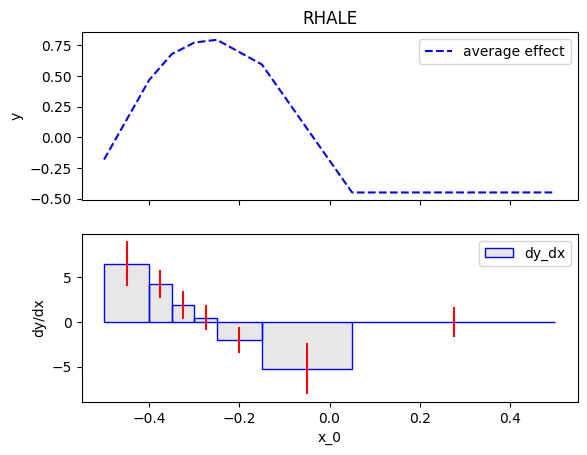

In [14]:
# DynamicProgramming
feat = 0
rhale = effector.RHALE(data=x, model=f, model_jac=dfdx, axis_limits=axis_limits)
binning = effector.axis_partitioning.DynamicProgramming(max_nof_bins=20, min_points_per_bin=10, discount=0.2)
rhale.fit([feat], binning_method=binning)
rhale.plot(feature=feat, heterogeneity="std", show_avg_output=False)

## PDP family of methods

We have invested a significant amount of time in exploring ALE and RHALE, attempting to achieve the most accurate approximation of the ALE definition. Is it worthwhile? For instance, PDP-ICE is a widely used method for both average effect and heterogeneity. So, why not opt for PDP-ICE instead of delving into these sophisticated ALE approximations?

In short, yes, especially in scenarios where the features exhibit correlation. Both PDP and ICE operate under the implicit assumption of feature independence. In cases where this assumption is substantially violated, relying on PDP and ICE may result in erroneous conclusions, stemming from extrapolation into unobserved regions.

In our example, it is evident that $x_3$ is highly dependent on $x_1$. Therefore, let's examine the implications of employing PDP-ICE.


### PDP and ICE definition

The PDP is defined as **_the average prediction over the entire dataset when setting the feature of interest at a specific value._**:

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

The ICE plots show the ouput of instance $i$ if changing the feature of interest $x_s$:

$$\text{ICE}^{(i)}(x_s, x^{(i)}_c) = f(x_s, x^{(i)}_c)$$

ICE plots are plotted of the PDP.

In our example, the PDP and ICE plots are:

$$\text{PDP}(x_1) = \mathbb{E}_{x_2, x_3}[f(x_1, x_2, x_3)] = \sin(2\pi x_1) \mathbb{1}_{x_1<0} - \frac{5}{3} \sin(2\pi x_1)$$

$$\text{ICE}^{(i)}(x_1, x^{(i)}_2, x^{(i)}_3) = f(x_1, x^{(i)}_2, x^{(i)}_3) = \sin(2\pi x_1) (\mathbb{1}_{x_1<0} - 2 \mathbb{1}_{x_3^{(i)}} < 0) + x_1 x_2^{(i)}$$
 



In [15]:
def gt_pdp(x):
    y = np.sin(2 * np.pi * x) * (x < 0) - 5/3 * np.sin(2 * np.pi * x)
    return y

def gt_ice(x, N):
    K = x.shape[0]
    x3 = np.random.uniform(0, 6, N)
    ind_1 = x3 < 5
    x_2_i = np.random.normal(0, 2, N)
    
    y = np.stack([np.sin(2 * np.pi * x) * (x < 0) for _ in range(N)], 0)
    y[ind_1, :] -= np.stack([2 * np.sin(2 * np.pi * x) for _ in range(N)], 0)[ind_1, :]
    y += np.stack([x * x_2_i[i] for i in range(N)], 0)
    return y

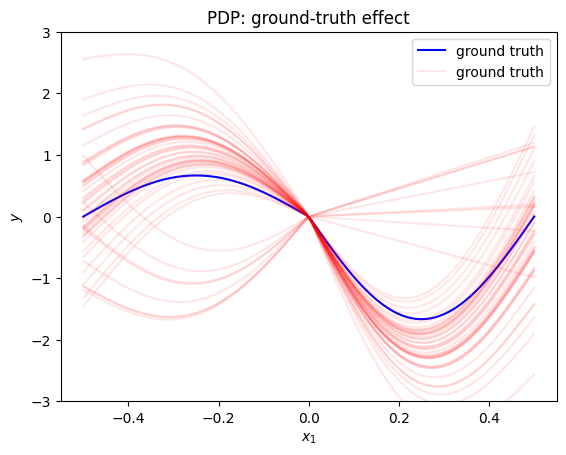

In [16]:
plt.figure()
plt.ylim(-3, 3)
xx = np.linspace(-.5, .5, 100)
plt.plot(xx, gt_pdp(xx), "b", label="ground truth")
plt.plot(xx, gt_ice(xx, 50)[0], color="red", label="ground truth", alpha=0.1)
plt.plot(xx, gt_ice(xx, 50)[1:].T, color="red", alpha=0.1)
plt.title("PDP: ground-truth effect")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()
plt.show()

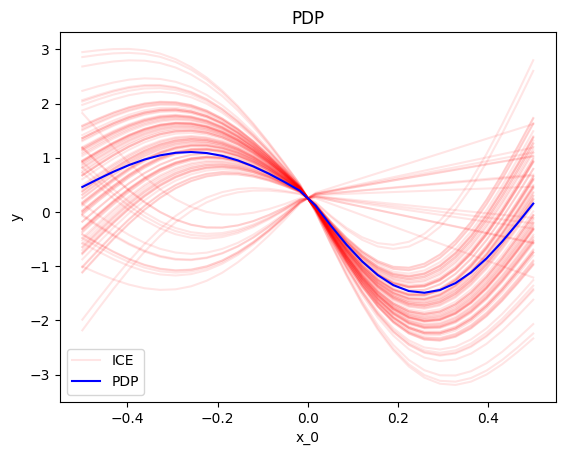

In [17]:
effector.PDP(data=x, model=f, nof_instances=100).plot(feature=0, centering=True, heterogeneity="ice")

It is crucial to recognize that heterogeneity arises from extrapolation into regions with low density. For instance, considering the data-generating distribution, it is highly improbable to observe a scenario where x_1<0 and x_3>0. However, PDP-ICE disrupts this correlation, leading some individual conditional expectations (ICEs) to trace $-\sin(2\pi x_1)$ within the interval $[-0.5, 0]$.

### d-PDP and d-ICE definition and approximation

The d-PDP and d-ICE are the derivative of the PDP and ICE, respectively. The d-PDP is the effect of the feature of interest on the model output. The d-ICE is the effect of the feature of interest on the model output for a specific instance.

In our example, the d-PDP and d-ICE plots are:

$$\text{d-PDP}(x_1) = \frac{\partial}{\partial x_1} \mathbb{E}_{x_2, x_3}[f(x_1, x_2, x_3)] = - 2 \pi \cos(2 \pi x_1) \mathbb{1}_{x_1<0} - \frac{10 \pi}{3} \cos(2 \pi x_1)$$

$$\text{d-ICE}^{(i)}(x_1, x^{(i)}_2, x^{(i)}_3) = \frac{\partial}{\partial x_1} f(x_1, x^{(i)}_2, x^{(i)}_3) = 2 \pi \cos(2 \pi x_1) (\mathbb{1}_{x_1<0} - 2 \mathbb{1}_{x_3^{(i)}} < 0) + x_2^{(i)}$$



In [18]:
def gt_d_pdp(x):
    y = 2 * np.pi * np.cos(2 * np.pi * x) * (x < 0) - 10 * np.pi / 3 * np.cos(2 * np.pi * x) + 1
    return y

def gt_d_ice(x, N):
    K = x.shape[0]
    x3 = np.random.uniform(0, 6, N)
    ind_1 = x3 < 5
    x_2_i = np.random.normal(0, 2, N)

    y = np.stack([2 * np.pi * np.cos(2 * np.pi * x) * (x < 0) for _ in range(N)], 0)
    y[ind_1, :] -= np.stack([4 * np.pi * np.cos(2 * np.pi * x) for _ in range(N)], 0)[ind_1, :]
    y += np.expand_dims(x_2_i, -1)
    return y

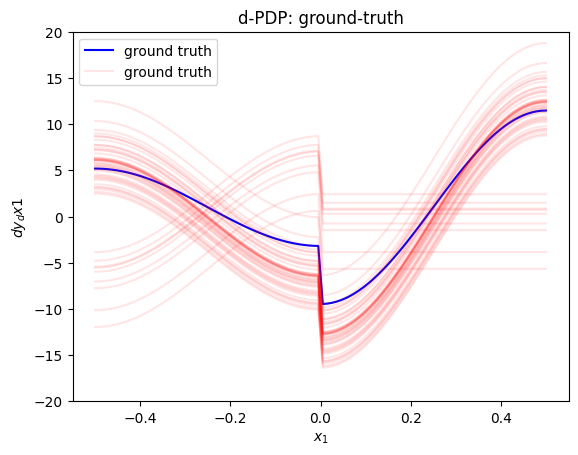

In [19]:
plt.figure()
plt.ylim(-20, 20)
xx = np.linspace(-.5, .5, 100)
plt.plot(xx, gt_d_pdp(xx), "b", label="ground truth")
plt.plot(xx, gt_d_ice(xx, 50)[0], color="red", label="ground truth", alpha=0.1)
plt.plot(xx, gt_d_ice(xx, 50)[1:].T, color="red", alpha=0.1)
plt.title("d-PDP: ground-truth")
plt.xlabel("$x_1$")
plt.ylabel("$dy_dx1$")
plt.legend()
plt.show()

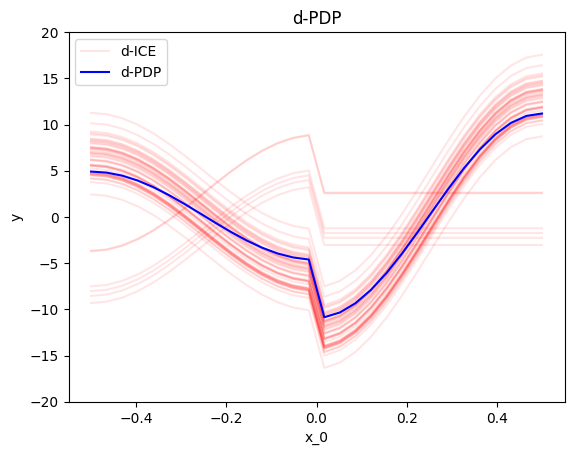

In [20]:
effector.DerPDP(data=x, model=f, model_jac=dfdx, nof_instances=50).plot(feature=0, centering=False, heterogeneity="ice", dy_limits=[-20, 20])

## SHAP Dependence Plots



In [21]:
def gt_shape(x):
    y = -5/6*np.sin(2 * np.pi * x)
    return y

def gt_shap_values(N):
    N1 = int(5*N/6)
    N2 = N - N1
    x = generate_samples(N1, N2, sigma_2=sigma_2, sigma_3=sigma_3)
    
    # drop when x_1 < 0.5 or > 0.5
    x = x[np.logical_and(x[:, 0] >= -0.5, x[:, 0] <= 0.5), :]
    
    y = -5/6 * np.sin(2 * np.pi * x[:, 0])
    y += 1/2 * x[:, 0] * x[:, 1] 
    y += 1/32 * x[:, 2]
    return x[:, 0], y
    

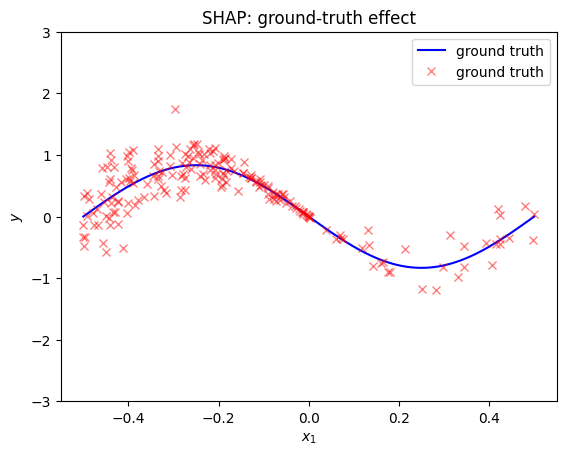

In [22]:
x_shap, y_shap = gt_shap_values(200)
plt.figure()
plt.ylim(-3, 3)
xx = np.linspace(-.5, .5, 100)
plt.plot(xx, gt_shape(xx), "b", label="ground truth")
plt.plot(x_shap[0], y_shap[0], "rx", label="ground truth", alpha=.5)
plt.plot(x_shap[1:], y_shap[1:], "rx", alpha=0.5)
plt.title("SHAP: ground-truth effect")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()
plt.show()


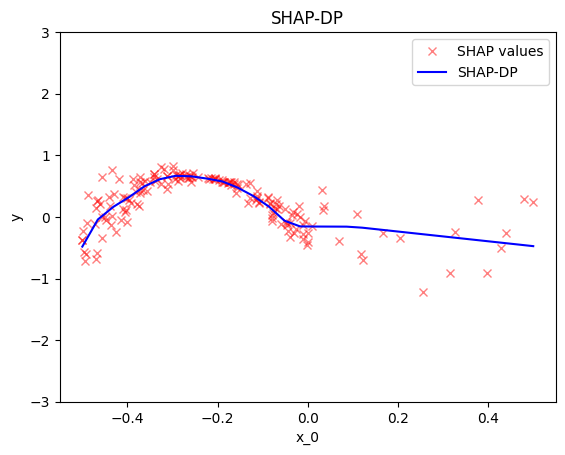

In [32]:
shap_dp = effector.ShapDP(data=x, model=f, nof_instances="all")
shap_dp.fit(features=0, binning_method=effector.axis_partitioning.Greedy(init_nof_bins=30, min_points_per_bin=10, discount=0.2))
shap_dp.plot(feature=0, centering=True, heterogeneity="shap_values", y_limits=[-3, 3])